<h1>Exploratory Configuration of a Multilayer Perceptron Network for Time Series Forecasting</h1><br>
https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/

<h2>Data Preparation</h2><br>
1. Transform the time series data so that it is stationary.<br>
Specifically, a log=1 differencing to remove the increasing trend in the data<br>
2. Transform the time series into a supervised learning problem. <br>
Specifically, the orgranization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current timestep<br>
3.Trnsform the observations to have a specific sacle.<br>
Specifically, to rescale the data to values between -1 and 1

<h2>1. Load input</h2>

In [1]:
import sys
# add util lib path
sys.path.append('/Users/gonsoomoon/Documents/DeepLearning/rnn/time_series_prediction/util')

In [2]:
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
import ts_input  as ui   # user-defined lib
from pandas import DataFrame
shampoo_input = '../input/sales-of-shampoo-over-a-three-ye.csv'
series = ui.load_series_data(shampoo_input)

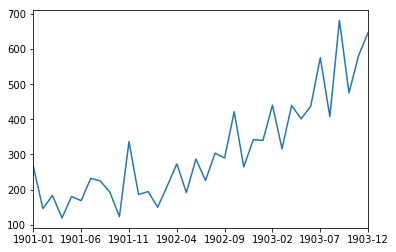

In [3]:

def convert_to_datestring(idx):
    dt = []
    for i in idx:
        s_date = "190" + str(i[3]) + str(i[4:7])
        dt.append(s_date)
        #print(date)
    return dt

dt = convert_to_datestring(series.index)
#print(dt)
#DatetimeIndex.strftime(date_format
series.index = dt
series.plot()
pyplot.show()



<h2>2. Make supervised feature set</h2>

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
# matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


<h2>2.1. Utility functions</h2>

In [5]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan=True):
    """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... , t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ...t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [6]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

In [7]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [57]:
# scale train and test data to [-1, 1]
def scale(train, test, verbose=False):
    if verbose:
        print("type of train : ", type(train))
        print("shape of train : ", train.shape)       
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # transform train
    row = train.shape[0]
    col = train.shape[1]
    train = train.reshape(row, col)
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [58]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat, verbose=False):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    if verbose:
        print("new_row: ", new_row)
        print("array: ", array)
        print("inverted: ", inverted)
    return inverted[0, -1]

In [59]:
# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons, verbose=False):
    if verbose:
        print("train: \n", train)
        print("batch_size: \n", batch_size)   
        print("nb_epoch: \n", nb_epoch)   
        print("neurons: \n", neurons)           
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X,y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

<h2>2.2. Check a value validation</h2>

<h2>2.3. Model functions</h2>

In [60]:
import pandas as pd
def save_csv_file(data, filename="../debug/df.csv"):
    #print("type is :", type(data))
    if (type(data) is Series):
        df = pd.DataFrame(data.values.reshape(-1,1))
    elif (type(data) is numpy.ndarray):
        df = pd.DataFrame(data)
    elif (type(data) is list):
        df = pd.DataFrame(data)
    elif(type(data) is pd.DataFrame):
        df = data
    else:
        print(" data is not either Series or numpy.array")
        return None
    df.to_csv(filename)

In [61]:
def make_supervised_feature(data, lag, kind="train",verbose=False):
    raw_values = data
    diff_values = difference(raw_values,1) # 1 means subtraction from the previous element
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:, :]
    if verbose:
        if kind == "train":
            save_csv_file(raw_values, "../debug/train_raw_values.csv")
            save_csv_file(diff_values, "../debug/train_diff_values.csv")
            save_csv_file(supervised, "../debug/train_supervised.csv")   
            save_csv_file(supervised_values, "../debug/train_supervised_values.csv")
        else:
            save_csv_file(raw_values, "../debug/test_raw_values.csv")
            save_csv_file(diff_values, "../debug/test_diff_values.csv")
            save_csv_file(supervised, "../debug/test_supervised.csv")   
            save_csv_file(supervised_values, "../debug/test_supervised_values.csv")

            
    return supervised_values

In [62]:
# invert differenced value
def inverse_difference(history, invert_output, interval=1, verbose=False):
    raw_item = history[-interval]        
    predict_item = invert_output + raw_item
    return predict_item, invert_output, raw_item

In [63]:
def convert_prediction(scaler, output, test_scaled, raw_values, verbose=False):
    prediction_list = list()
    invert_output_list = list()
    raw_list = list()
    for i in range(len(output)):
        output_item = output[i,0]
        X = test_scaled[i, 0:-1]
        # invert scaling
        invert_output = invert_scale(scaler, X, output_item)
        # invert differencing
        # predict_item = invert_output + raw_diff
        predict_item, invert_output, raw_item  = inverse_difference(raw_values, invert_output, len(test_scaled)+1-i)
        # store forecast
        prediction_list.append(predict_item)
        invert_output_list.append(invert_output)
        raw_list.append(raw_item)
    return prediction_list, invert_output_list, raw_list

In [95]:
# run a repeated experiment
def experiment(repeats, epochs, neurons, scaler, series, train_scaled, test_scaled, train_size, batch_size=4, verbose=False):
    ##train_trimmed = train_scaled[2:, :]
    error_scores = list()
    raw_values = series.values
        
    for r in range(repeats):
        # fit the model
        model = fit_model(train_scaled, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:, 0:-1] # Only extract X not y
        output = model.predict(test_reshaped, batch_size=batch_size)
        # Recover original value
        predictions, invert_output_list, raw_list = convert_prediction(scaler, output, test_scaled, raw_values, verbose=True)
        # report performance
        #print("predictions len: ", len(predictions))
        #print("raw values len:", len(raw_values[train_size:]))
        len_prediction= len(predictions) + 1
        print("len_prediction: ", len_prediction)
        true_values = raw_values[-len_prediction:-1]
        #print("true values len: ", len(true_values))
        #print("predictions len: ", len(predictions))        
        #print(true_values, "\n")
        #print(predictions)
        rmse = sqrt(mean_squared_error(true_values, predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        
        if verbose:
            save_csv_file(output, "../debug/output.csv")
            save_csv_file(true_values, "../debug/true_values.csv")
            save_csv_file(predictions, "../debug/predictions.csv")            
            save_csv_file(invert_output_list, "../debug/invert_output_list.csv")        
            save_csv_file(raw_list, "../debug/raw_list.csv")                
        
    return error_scores

In [102]:
#########################
# Parameters
#########################
TRAIN_SIZE = 21
REPEATS = 5
LAG = 1
NEURONS = 1
EPOCHS = [5, 10, 15, 20, 25]
BATCH_SIZE = 4

In [103]:
#########################
# Prepare for Input
#########################
# split data into train and test-sets
train, test = series.values[0:TRAIN_SIZE], series.values[TRAIN_SIZE:]
print("train len: ", len(train))
print("test len: ", len(test))
train_supervised_values = make_supervised_feature(train, LAG, kind="train", verbose=True)
test_supervised_values = make_supervised_feature(test, LAG, kind="test", verbose=True)
print("train_supervised_values len: ", len(train_supervised_values))
print("test_supervised_values len: ", len(test_supervised_values))

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train_supervised_values, test_supervised_values, verbose=False)
save_csv_file(train_scaled, "../debug/train_scaled.csv")
save_csv_file(test_scaled, "../debug/test_scaled.csv")


train len:  21
test len:  15
train_supervised_values len:  19
test_supervised_values len:  13


len_prediction:  14
1) Test RMSE: 42.736
len_prediction:  14
2) Test RMSE: 23.448
len_prediction:  14
3) Test RMSE: 71.791
len_prediction:  14
4) Test RMSE: 26.920
len_prediction:  14
5) Test RMSE: 72.587
len_prediction:  14
1) Test RMSE: 31.536
len_prediction:  14
2) Test RMSE: 92.586
len_prediction:  14
3) Test RMSE: 83.049
len_prediction:  14
4) Test RMSE: 44.011
len_prediction:  14
5) Test RMSE: 153.887
len_prediction:  14
1) Test RMSE: 57.996
len_prediction:  14
2) Test RMSE: 82.897
len_prediction:  14
3) Test RMSE: 41.104
len_prediction:  14
4) Test RMSE: 54.375
len_prediction:  14
5) Test RMSE: 76.024
len_prediction:  14
1) Test RMSE: 143.245
len_prediction:  14
2) Test RMSE: 119.384
len_prediction:  14
3) Test RMSE: 21.933
len_prediction:  14
4) Test RMSE: 67.566
len_prediction:  14
5) Test RMSE: 20.273
len_prediction:  14
1) Test RMSE: 32.981
len_prediction:  14
2) Test RMSE: 16.380
len_prediction:  14
3) Test RMSE: 13.351
len_prediction:  14
4) Test RMSE: 24.870
len_predictio

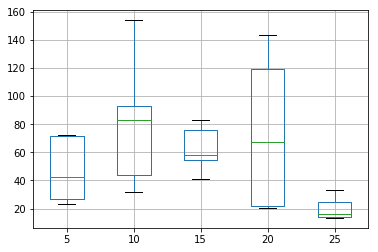

In [104]:

#########################
# Experiment
#########################
results = DataFrame()

for e in EPOCHS:
    results[str(e)] = experiment(REPEATS, e, NEURONS, scaler, series, 
                                 train_scaled, test_scaled, TRAIN_SIZE, BATCH_SIZE, verbose=True )
#########################
# Results
#########################, ver
# summarize results of RMSE
print(results.describe())
# save boxplot
results.boxplot()
pyplot.show()


In [6]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transforms data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        model = fit_model(train_trimmed, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:, 0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores



1) Test RMSE: 217.761
2) Test RMSE: 123.236
3) Test RMSE: 106.464
1) Test RMSE: 164.390
2) Test RMSE: 218.534
3) Test RMSE: 336.083
1) Test RMSE: 179.616
2) Test RMSE: 115.651
3) Test RMSE: 132.551
1) Test RMSE: 106.824
2) Test RMSE: 138.092
3) Test RMSE: 132.205
1) Test RMSE: 121.832
2) Test RMSE: 185.314
3) Test RMSE: 211.968
                3           5          10          15          20
count    3.000000    3.000000    3.000000    3.000000    3.000000
mean   149.153533  239.668793  142.606055  125.706859  173.037870
std     60.004511   87.776331   33.146746   16.616023   46.305158
min    106.464069  164.389557  115.651436  106.823757  121.831750
25%    114.849892  191.461650  124.100996  119.514387  153.572678
50%    123.235716  218.533742  132.550555  132.205017  185.313606
75%    170.498265  277.308412  156.083365  135.148411  198.640930
max    217.760815  336.083081  179.616175  138.091804  211.968255


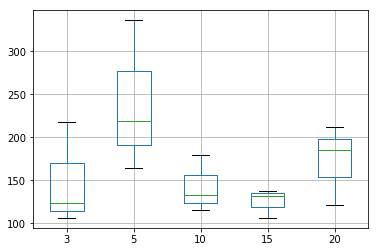

In [7]:
# experiment
#repeats = 30
repeats = 3
results = DataFrame()
lag = 1
neurons = 1
# vary training epochs
# epochs = [50, 100, 500, 1000, 2000]
epochs = [3, 5, 10, 15, 20]
for e in epochs:
    results[str(e)] = experiment(repeats, series, e, lag, neurons)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.show()

In [8]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:, -1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history



In [9]:
# run diagnostic experiments
def run(series):
    #repeats = 10
    repeats = 3
    n_batch = 4
    #n_epochs = 1000
    n_epochs = 1000
    n_neurons = 1
    n_lag = 1
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:, :]
    train, test = supervised_values[0:-12], supervised_values[-12:]
    scaler, train_scaled, test_scaled = scale(train, test)
    train_trimmed = train_scaled[2:, :]
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs,n_neurons )
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color = 'orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.show()
        

0) TrainRMSE=90.341007, TestRMSE=137.459028
1) TrainRMSE=60.287184, TestRMSE=90.118840
2) TrainRMSE=90.341007, TestRMSE=138.148449


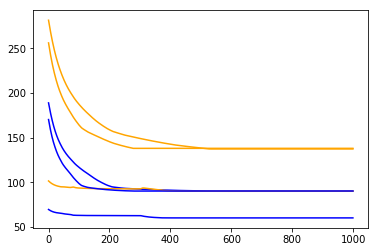

In [10]:
run(series)

<h2>Vary Hidden Layer Neurons</h2>

1) Test RMSE: 154.460
2) Test RMSE: 114.029
3) Test RMSE: 189.848
1) Test RMSE: 107.871
2) Test RMSE: 123.879
3) Test RMSE: 135.805
1) Test RMSE: 85.153
2) Test RMSE: 103.787
3) Test RMSE: 146.205
1) Test RMSE: 106.733
2) Test RMSE: 99.073
3) Test RMSE: 111.472
1) Test RMSE: 92.780
2) Test RMSE: 104.132
3) Test RMSE: 95.642
                1           2           3           4           5
count    3.000000    3.000000    3.000000    3.000000    3.000000
mean   152.779153  122.518091  111.715232  105.759561   97.518206
std     37.937369   14.016683   31.288284    6.256597    5.904191
min    114.029270  107.870735   85.153418   99.073182   92.780041
25%    134.244665  115.874699   94.470426  102.903245   94.211059
50%    154.460061  123.878663  103.787434  106.733307   95.642078
75%    172.154095  129.841769  124.996140  109.102750   99.887289
max    189.848129  135.804875  146.204845  111.472193  104.132499


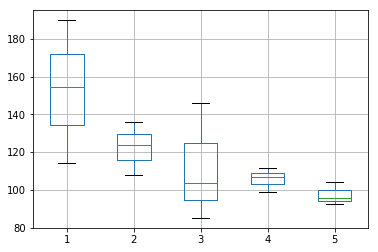

In [11]:
# experiment
#repeats = 30
repeats = 3
results = DataFrame()
lag = 1
#epochs = 1000
epochs = 100
neurons = [1, 2, 3, 4, 5]
for n in neurons:
    results[str(n)] = experiment(repeats, series, epochs, lag, n)
print(results.describe())
results.boxplot()
pyplot.show()

In [17]:
def run(series):
	# config
	#repeats = 10
    repeats = 3
    n_batch = 4
    n_epochs = 1000
    n_neurons = 3
    n_lag = 1
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.show()

0) TrainRMSE=60.233537, TestRMSE=93.515132
1) TrainRMSE=60.113774, TestRMSE=93.939950
2) TrainRMSE=62.563601, TestRMSE=92.644076


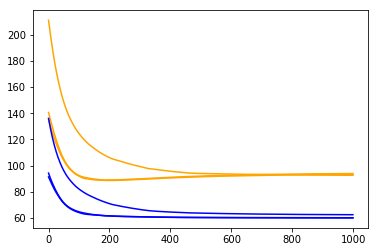

In [18]:
run(series)

<h2>Vary Hidden Layer Neurons with Lag</h2>

1) Test RMSE: 92.950
2) Test RMSE: 90.058
3) Test RMSE: 140.001
1) Test RMSE: 106.490
2) Test RMSE: 92.587
3) Test RMSE: 106.165
1) Test RMSE: 124.824
2) Test RMSE: 102.002
3) Test RMSE: 140.817
1) Test RMSE: 127.713
2) Test RMSE: 136.673
3) Test RMSE: 98.746
                1           3           5           7
count    3.000000    3.000000    3.000000    3.000000
mean   107.669752  101.747423  122.547506  121.043835
std     28.037299    7.934664   19.507515   19.823646
min     90.057731   92.587176  102.001572   98.745579
25%     91.503959   99.376281  113.412847  113.229418
50%     92.950187  106.165385  124.824122  127.713256
75%    116.475762  106.327547  132.820472  132.192963
max    140.001338  106.489708  140.816822  136.672670


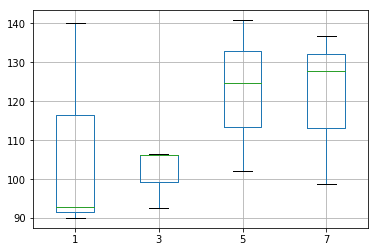

In [15]:
#repeats = 30
repeats = 3
results = DataFrame()
epochs = 1000
# vary neurons
neurons = [1, 3, 5, 7]
for n in neurons:
	results[str(n)] = experiment(repeats, series, epochs, n, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.show()

In [22]:
def run(series):
	# config
	repeats = 3
	n_batch = 2
	n_epochs = 1000
	n_neurons = 3
	n_lag = 3
	# load dataset
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# run diagnostic tests
	for i in range(repeats):
		history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.show()

0) TrainRMSE=56.908709, TestRMSE=82.331581
1) TrainRMSE=59.196322, TestRMSE=97.369186
2) TrainRMSE=46.752683, TestRMSE=115.719681


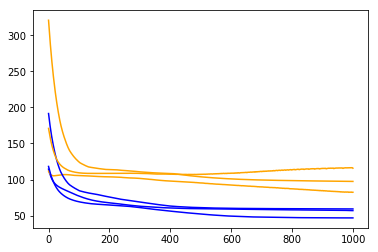

In [23]:
run(series)